In [2]:
%matplotlib inline

import pylab as plt
import numpy as np
from scipy.spatial import cKDTree
from bornagain import Molecule

In [49]:
# define a grid
grid_size = 80 # angstrom
grid_spacing = 0.5 # angstrom
Ngrid_pt = grid_size/grid_spacing

# load a molecule
mol = Molecule("2LYZ.pdb")
mol.atom_vecs -= mol.atom_vecs.mean(0)

In [129]:
def plot_dens(dens, grid_size=grid_size):
    plt.figure(figsize=(16,12))
    extent = (-grid_size/2, grid_size/2, grid_size/2, -grid_size/2)
    plt.subplot(131);plt.imshow( np.sum( dens, axis=2), extent=extent);plt.title("view along x-y");plt.ylabel('Angstrom')
    plt.subplot(132);plt.imshow( np.sum( dens, axis=1), extent=extent);plt.title("view along x-z");plt.xlabel('Angstrom')
    plt.subplot(133);plt.imshow( np.sum( dens, axis=0), extent=extent);plt.title("view along y-z")

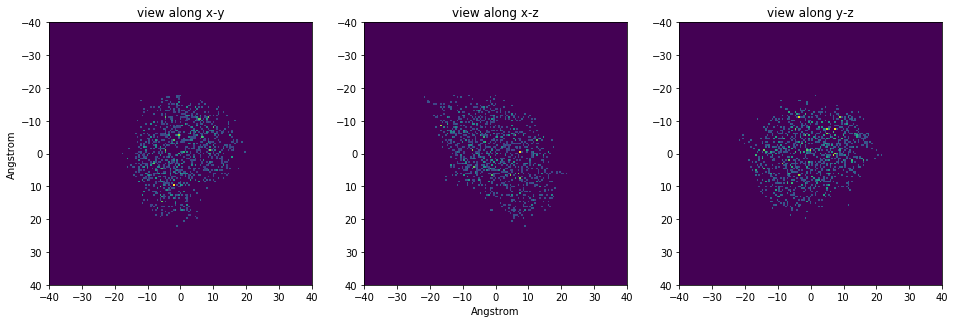

In [130]:
# originally wanted to used histogramdd, but then realized it fails for fine grids.. 
bins_on_d = np.linspace( - int(grid_size/2), int(grid_size/2), int(Ngrid_pt))
dens_bad = np.histogramdd(  mol.atom_vecs, [bins_on_d]*3, weights=mol.Z )[0]
plot_dens( dens_bad)

In [4]:
# so do a nearest neighbor assignment

x,y,z = np.mgrid[
        -grid_size/2:grid_size/2:Ngrid_pt*1j, 
        -grid_size/2:grid_size/2:Ngrid_pt*1j, 
        -grid_size/2:grid_size/2:Ngrid_pt*1j]

coors = np.array( zip(x.ravel(), y.ravel(), z.ravel() ))
KD_grid = cKDTree(coors)

In [54]:
# this works for fixed atom size
atom_size = 1.5
nearest_gridpts_to_atoms = KD_grid.query_ball_point( mol.atom_vecs, r=1.5)

In [55]:
dens = np.zeros( x.shape)
for i,nearest in enumerate( nearest_gridpts_to_atoms):
    idx = np.unravel_index( nearest, x.shape)
    dens[idx] += mol.Z[i]

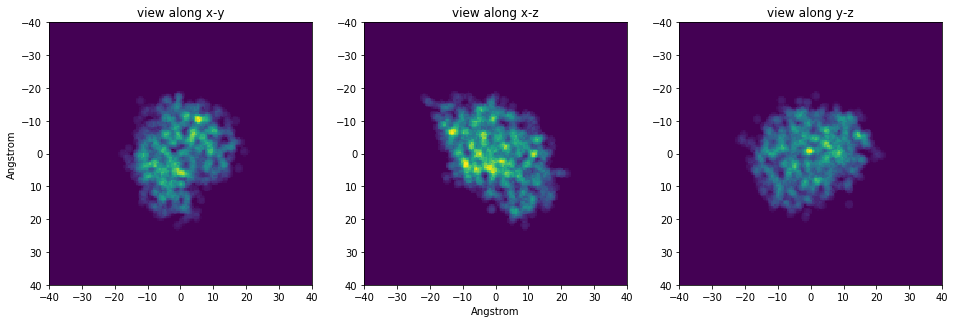

In [131]:
plot_dens(dens)

In [126]:
from scipy.fftpack import fftn, fftshift, fftfreq
Nfft = grid_size*2
diffrac = np.abs(fftshift(fftn(dens, shape=[Nfft,Nfft,Nfft])))**2

In [136]:
qmags = 2*np.pi*fftshift( fftfreq(Nfft, grid_spacing) )
qmin, qmax = qmags.min(), qmags.max()

Text(0.5,1,'view along qy-qz')

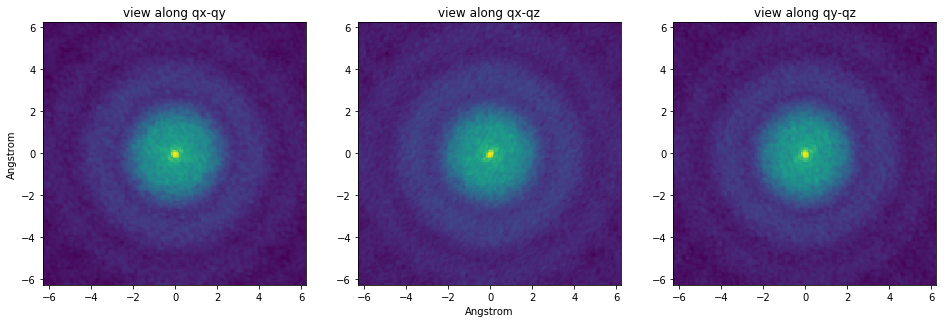

In [137]:
plt.figure(figsize=(16,12))
extent = (qmin, qmax, qmin, qmax)
plt.subplot(131);plt.imshow( np.sum( diffrac, axis=2), extent=extent , norm=plt.mpl.colors.LogNorm());plt.title("view along qx-qy");plt.ylabel('Angstrom')
plt.subplot(132);plt.imshow( np.sum( diffrac, axis=1), extent=extent,norm=plt.mpl.colors.LogNorm());plt.title("view along qx-qz");plt.xlabel('Angstrom')
plt.subplot(133);plt.imshow( np.sum( diffrac, axis=0), extent=extent,norm=plt.mpl.colors.LogNorm());plt.title("view along qy-qz")

In [157]:
from scipy.interpolate import RegularGridInterpolator as RGI
Interp = RGI([qmags]*3, diffrac)

In [158]:
from bornagain import SimplePAD
pad = SimplePAD( pixsize=0.0001, detdist=0.1, wavelen=1.305, n_pixels=512)
q_pixels = pad.Q_vectors

In [160]:
%%time 
img = Interp( q_pixels).reshape( pad.img_sh)

CPU times: user 188 ms, sys: 8.32 ms, total: 196 ms
Wall time: 122 ms


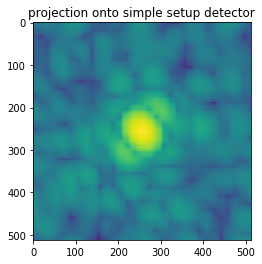

In [185]:
# plot the interpolation on the detector
plt.imshow( img, norm=plt.mpl.colors.LogNorm() )
_=plt.title("projection onto simple setup detector")

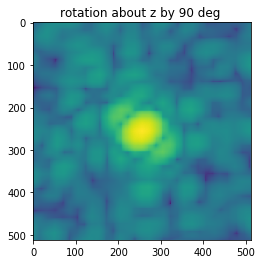

In [180]:
# rotate the molecule about Z-axis 90 degrees
Rot90 = np.array([[0,-1,0], [1, 0, 0], [0, 0, 1]])
q_pixels_R90 = np.dot( Rot90.T, q_pixels.T).T # left multiply

imgR90 = Interp( q_pixels_R90).reshape( pad.img_sh)
plt.imshow( imgR180, norm=plt.mpl.colors.LogNorm() )
_=plt.title("rotation about z by 90 deg")

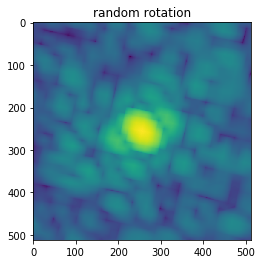

In [178]:
# do a random rotation
from bornagain.utils import random_rotation as RandRot

q_pixels_randrot = np.dot( RandRot().T, q_pixels.T).T
img_randrot = Interp( q_pixels_randrot).reshape( pad.img_sh)
plt.imshow( img_randrot, norm=plt.mpl.colors.LogNorm() )
_=plt.title("random rotation")